# SST correlation & regression maps 
# *for a leading EOF of a chosen box*

## Regressed on a time series which is filtered to different frequencies

In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
import cartopy.crs as ccrs

In [4]:
# NOAA PSD https://psl.noaa.gov/data/gridded/index.html

URL = 'https://psl.noaa.gov//thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
#thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
ds = xr.open_dataset(URL)
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2020, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-04-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-05-05
    DODS_EXTRA.Unlimited_Dimension:  time

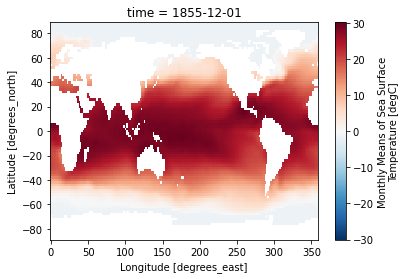

In [5]:
ds.sst[23].plot()

In [33]:
# Pick a point or box 
#BOX = ds.sst.sel(lat=20,lon=300).drop_vars(['lat','lon'])

# Atlantic roughly 
BOX = ds.sst.sel( lat=slice(40,0),lon=slice(250,350) )

# EOF(lat,lon)PC(time) decomposition of box
## Prefiltering in time could be added here: 
### - remove seasonal cycle and detrend
### - sel( time = slice(late 2oth century only) ) 
### - filter for some frequency band (decadal, interannual, etc.) 
### - rolling(3, center=True).mean() for seasonal means

In [66]:
# Prefiltering in time, nothing here by default
BOX = BOX 

In [34]:
# EOFs of the BOX SST(lon, lat, time). 
# https://ajdawson.github.io/eofs/latest/api/eofs.xarray.html

from eofs.xarray import Eof

NEOF = 3 
solver = Eof( BOX )
pc = solver.pcs(npcs=NEOF)  #, pcscaling=1)
eofs = solver.eofs(neofs=NEOF)

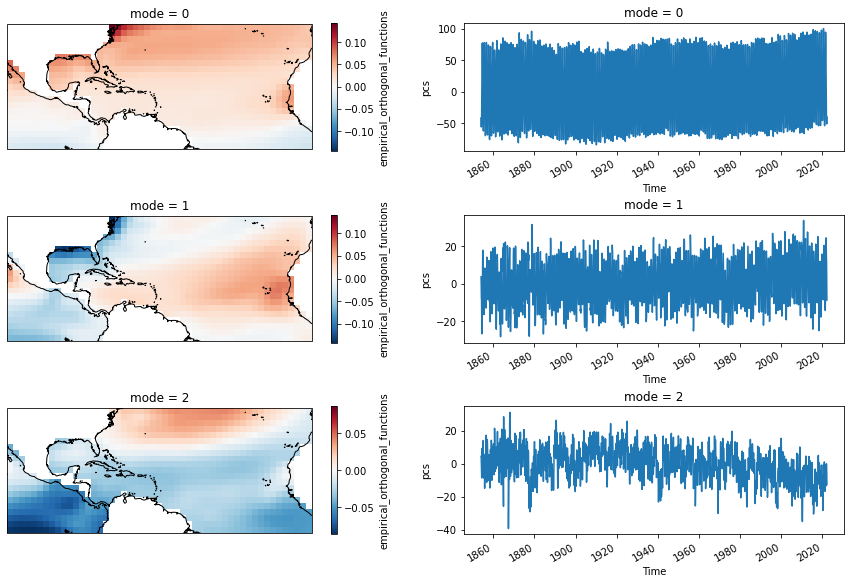

In [35]:
# Depict  results:
projection = ccrs.PlateCarree()
plt.figure(figsize=(15, 20)) #, subplot_kw=dict(projection=projection))
plt.subplots_adjust(hspace=0.5)
#plt.suptitle('EOFs and PCs of box SST (no time pre-filtering for now)')

for i in range(3):
    ax = plt.subplot(NEOF*2, 2, 2*i + 1, projection=projection)
    eofs[i].plot() 
    ax.coastlines();

    ax = plt.subplot(NEOF*2, 2, 2*i + 2)
    pc[:,i].plot()  

# Select a time series, and decompose it
## trend, LF, BP, HF, ... 

In [36]:
myts = pc[:,1]

# regress on time to get trend

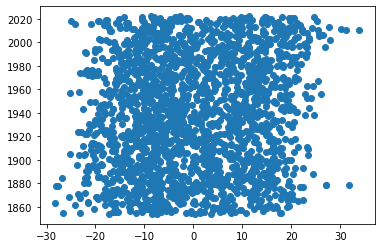

In [38]:
plt.scatter(myts.values, myts.time.values)

In [39]:
# correlation with time is the trend: upward (positive) 0.16435173719492452
timecor = np.corrcoef(myts.values, range(myts.size))[1,0]; timecor

0.1442311471885333

583.1237004272764

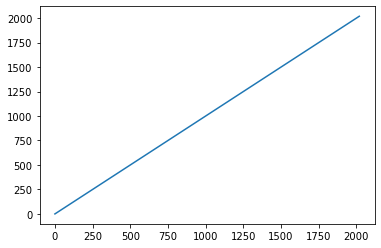

In [40]:
# stdev of a linear trend: units are months 
plt.plot(range(myts.size))
np.std( range(myts.size) )

In [41]:
# stdev of SST 
np.std( myts ).values

array(12.138626, dtype=float32)

In [42]:
# Slope is K/month units 
slope = timecor *np.std(myts).values /np.std( range(myts.size) ); slope

# Trend is a time series of the right shape, equal to the mean plos the trend
trend = myts.copy()*0 +myts.mean() + slope*range(myts.size)

Text(0.5, 1.0, '0N, 180E SST and trend')

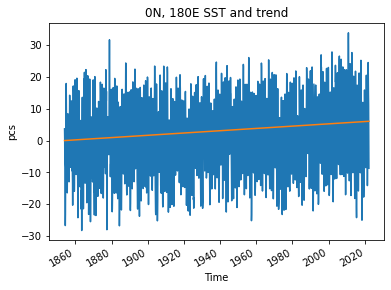

In [43]:
myts.plot(); trend.plot(); plt.title('0N, 180E SST and trend')

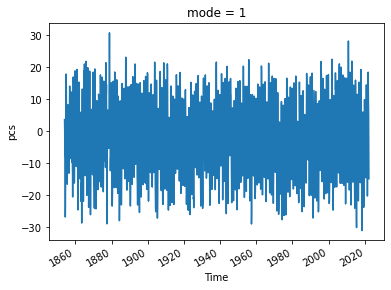

In [44]:
detrend = myts-trend
detrend.plot()

# Regress on month of year (mm) to get seasonal cycle

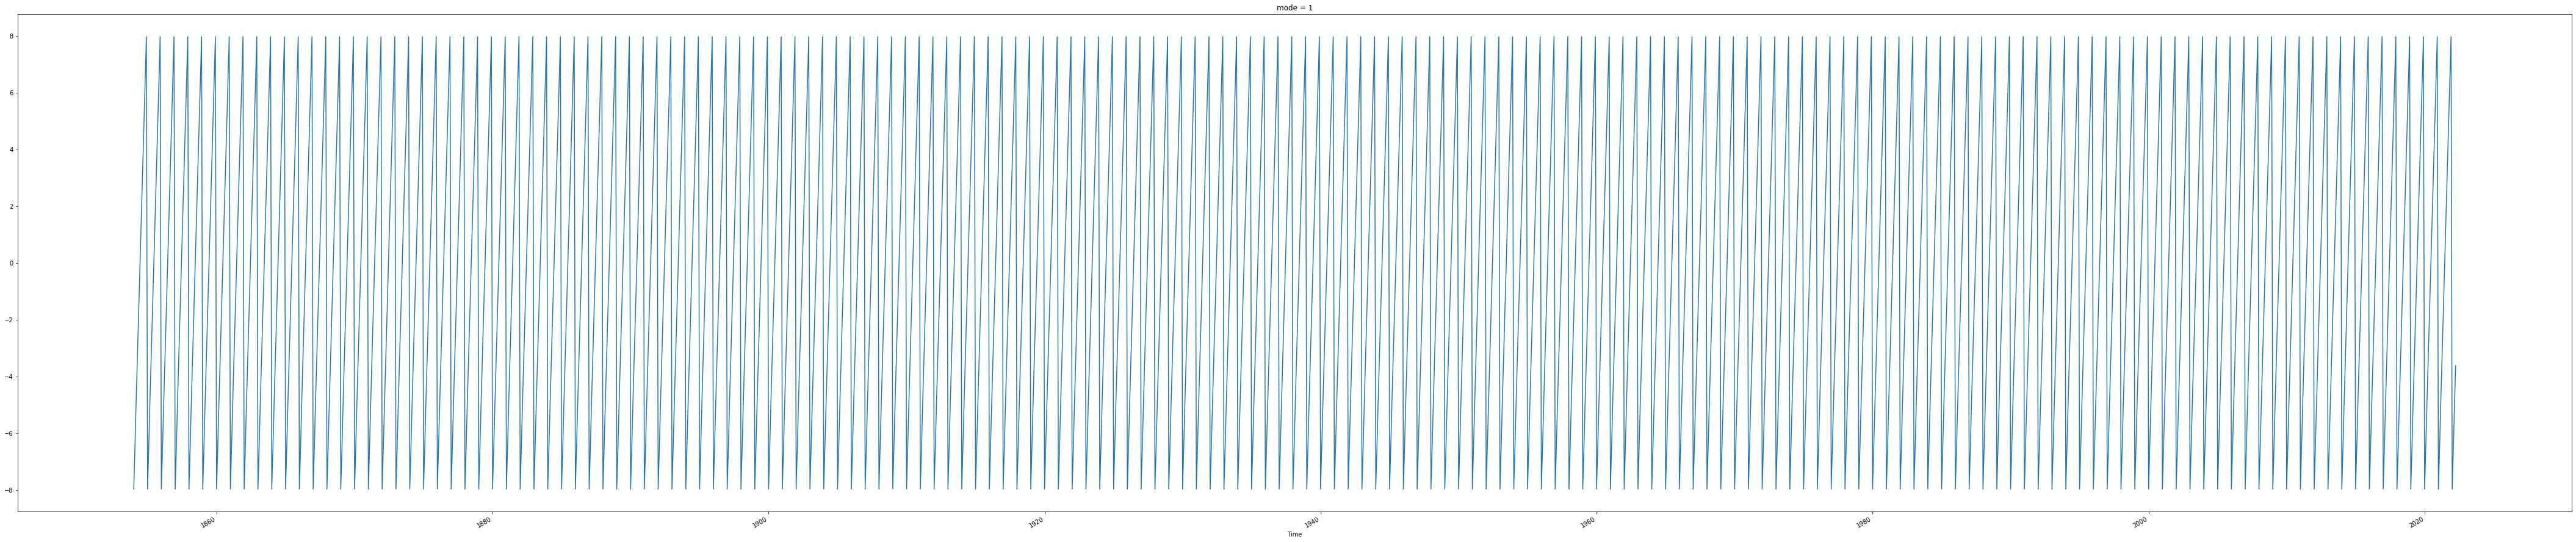

In [45]:
mm = myts['time.month'] 

mmcor = np.corrcoef(detrend.values, mm)[1,0]      # in [-1,1]
slope = mmcor *np.std(detrend).values /np.std(mm) # K/month units

# seas12 is a time series of the right shape, linear regression slope on mm-mm.mean()
seas12 = detrend.copy()*0 + slope*(mm - mm.mean())
seas12.plot(size=15,aspect=5)

Text(0.5, 1.0, 'Detrended blue, deseasonalized orange')

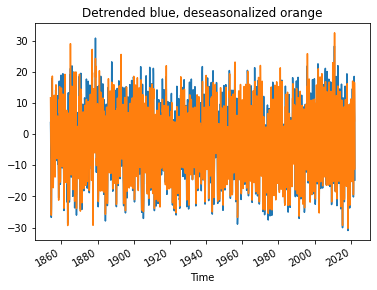

In [46]:
deseas = detrend-seas12
detrend.plot(); deseas.plot(); plt.title('Detrended blue, deseasonalized orange')

# Now low-pass (LP), band-pass(BP), and residual high pass (HP)


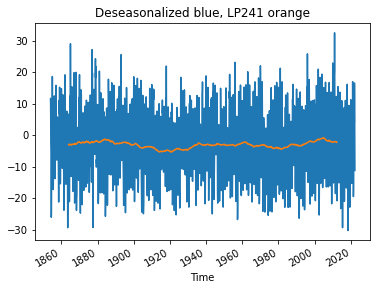

In [47]:
# LP is rolling means over 241 months (20 years)
LP = deseas.rolling(time=241, center=True).mean()# .dropna("time")

deseas.plot(); LP.plot()
plt.title('Deseasonalized blue, LP241 orange')
resid = deseas-LP

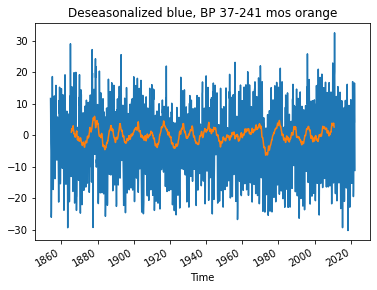

In [48]:
# BP is rolling mean of resid over 49 months (4 years)
BP = resid.rolling(time=37, center=True).mean() #.dropna("time")

deseas.plot(); BP.plot()
plt.title('Deseasonalized blue, BP 37-241 mos orange')
HP = resid-BP

Text(0.5, 1.0, 'HP (49 mos) and VHP (13 mos)')

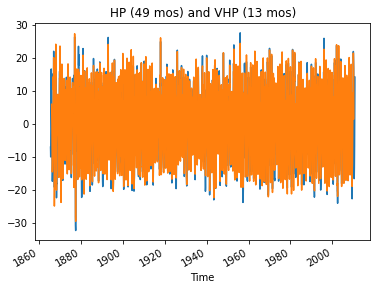

In [49]:
VHP = HP.copy()-HP.rolling(time=13, center=True).mean() #.dropna("time")

HP.plot(); VHP.plot(); plt.title('HP (49 mos) and VHP (13 mos)')

# Shuffle time series: a null hypothesis 
Careful, it is shuffled in place, not returned as a result! Do it on a copy

In [50]:
RND = myts.copy()
np.random.shuffle(RND)

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_6373/3171758192.py:2: UserWarning: you are shuffling a 'DataArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(RND)


# Make correlation and regression maps from time series: 
## Full myts, and its trend, seas12, LP, BP, HP, VHP.

Regress on SST itself: units are K/K, guaranteed to be about 1 in the myts itself in each panel. 

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
tsnames = ['trend','seas12','LP','BP','VHP','myts','RND']

In [53]:
for tsname in tsnames: 
    command = tsname+'corr = xr.corr('+tsname+',ds.sst, dim="time");'# +tsname+'cov.plot(); plt.title('+tsname+')'
    print(command)
    exec(command)
    command = tsname+'reg = '+tsname+'corr'+'* ds.sst.std(dim="time") /'+tsname+'.std(dim="time")'
    print(command)
    exec(command)

trendcorr = xr.corr(trend,ds.sst, dim="time");
trendreg = trendcorr* ds.sst.std(dim="time") /trend.std(dim="time")
seas12corr = xr.corr(seas12,ds.sst, dim="time");
seas12reg = seas12corr* ds.sst.std(dim="time") /seas12.std(dim="time")
LPcorr = xr.corr(LP,ds.sst, dim="time");
LPreg = LPcorr* ds.sst.std(dim="time") /LP.std(dim="time")
BPcorr = xr.corr(BP,ds.sst, dim="time");
BPreg = BPcorr* ds.sst.std(dim="time") /BP.std(dim="time")
VHPcorr = xr.corr(VHP,ds.sst, dim="time");
VHPreg = VHPcorr* ds.sst.std(dim="time") /VHP.std(dim="time")
mytscorr = xr.corr(myts,ds.sst, dim="time");
mytsreg = mytscorr* ds.sst.std(dim="time") /myts.std(dim="time")
RNDcorr = xr.corr(RND,ds.sst, dim="time");
RNDreg = RNDcorr* ds.sst.std(dim="time") /RND.std(dim="time")


trend.plot()
trendcorr.plot(); plt.title('trend correlation coeff.')
seas12.plot()
seas12corr.plot(); plt.title('seas12 correlation coeff.')
LP.plot()
LPcorr.plot(); plt.title('LP correlation coeff.')
BP.plot()
BPcorr.plot(); plt.title('BP correlation coeff.')
VHP.plot()
VHPcorr.plot(); plt.title('VHP correlation coeff.')
myts.plot()
mytscorr.plot(); plt.title('myts correlation coeff.')
RND.plot()
RNDcorr.plot(); plt.title('RND correlation coeff.')


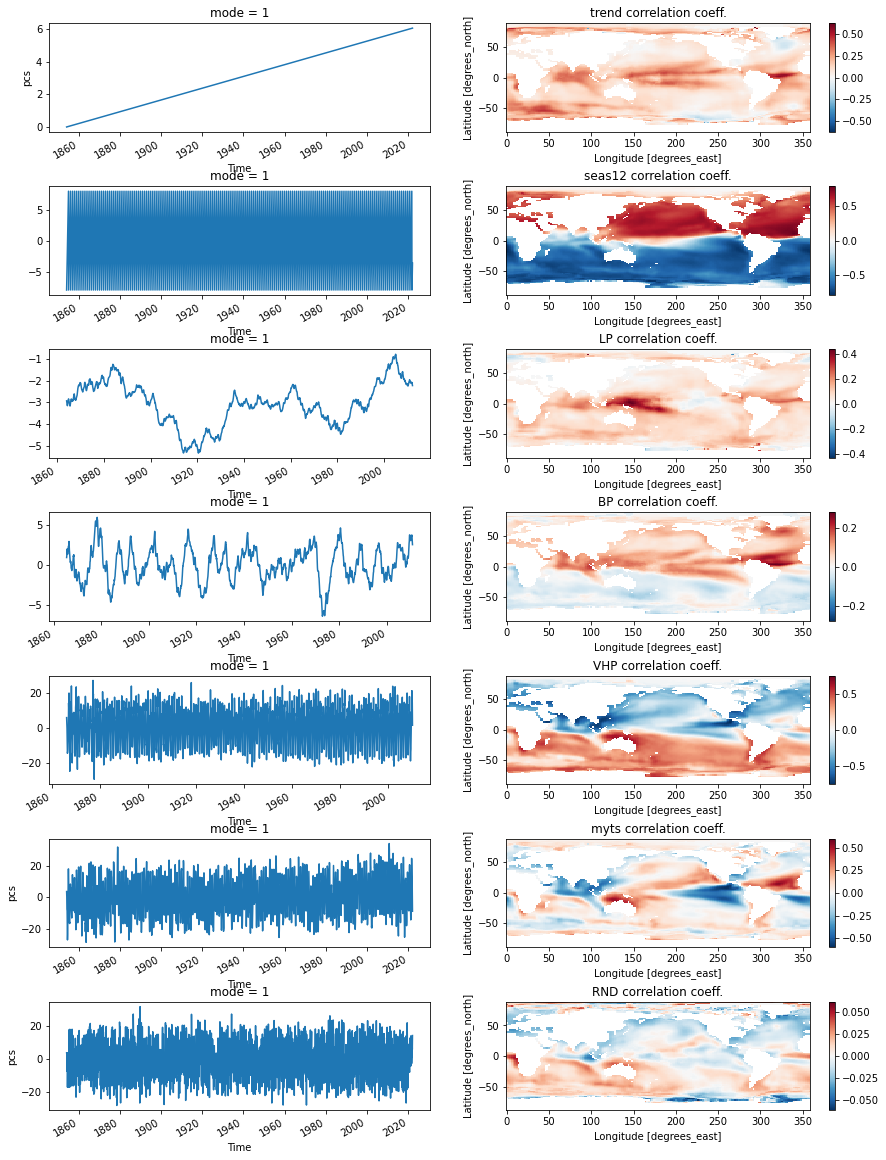

In [54]:
# CORRELATION COEFFICIENTS

plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
NPLOTS = len(tsnames)

#fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,10))

for i,tsname in enumerate(tsnames):
    ax = plt.subplot(NPLOTS, 2, 2*i + 1)
    command = tsname+".plot()"
    print(command)
    exec(command)

    ax = plt.subplot(NPLOTS, 2, 2*i + 2)
    command = tsname+"corr.plot(); plt.title('"+tsname+" correlation coeff.')"
    print(command)
    exec(command)

trend.plot()
trendreg.plot(); plt.title('trend regression (gridpt units/ts unit)')
seas12.plot()
seas12reg.plot(); plt.title('seas12 regression (gridpt units/ts unit)')
LP.plot()
LPreg.plot(); plt.title('LP regression (gridpt units/ts unit)')
BP.plot()
BPreg.plot(); plt.title('BP regression (gridpt units/ts unit)')
VHP.plot()
VHPreg.plot(); plt.title('VHP regression (gridpt units/ts unit)')
myts.plot()
mytsreg.plot(); plt.title('myts regression (gridpt units/ts unit)')
RND.plot()
RNDreg.plot(); plt.title('RND regression (gridpt units/ts unit)')


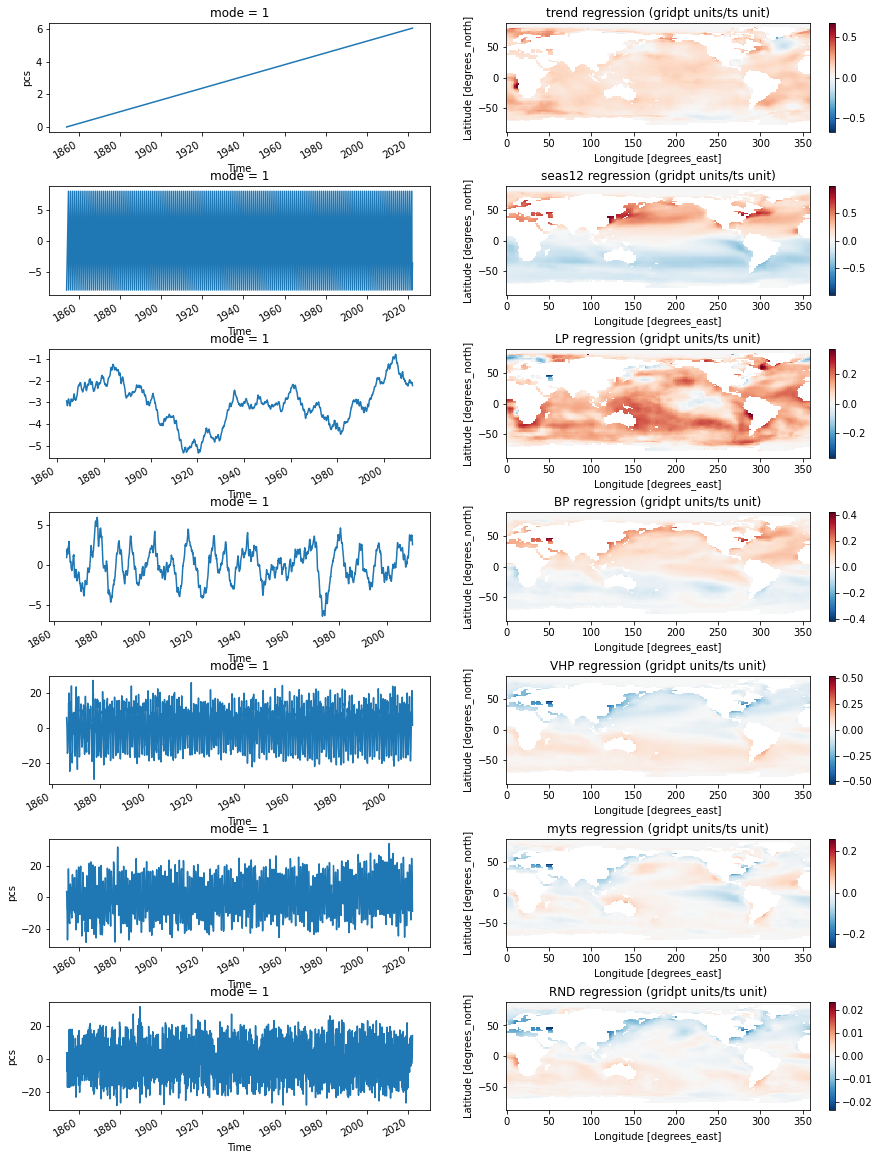

In [55]:
# REGRESSION COEFFICIENT

plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
NPLOTS = len(tsnames)

#fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,10))

for i,tsname in enumerate(tsnames):
    ax = plt.subplot(NPLOTS, 2, 2*i + 1)
    command = tsname+".plot()"
    print(command)
    exec(command)

    ax = plt.subplot(NPLOTS, 2, 2*i + 2)
    command = tsname+"reg.plot(); plt.title('"+tsname+" regression (gridpt units/ts unit)')"
    print(command)
    exec(command)

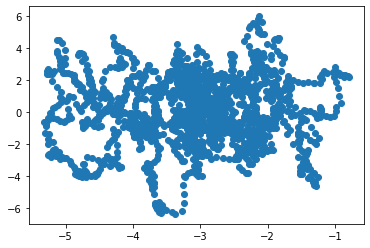

In [56]:
plt.scatter(LP,BP) # uncorrelated: orthogonal predictors, separable results

In [65]:
xr.corr?

Signature: xr.corr(da_a, da_b, dim=None)
Docstring:
Compute the Pearson correlation coefficient between
two DataArray objects along a shared dimension.

Parameters
----------
da_a : DataArray
    Array to compute.
da_b : DataArray
    Array to compute.
dim : str, optional
    The dimension along which the correlation will be computed

Returns
-------
correlation: DataArray

See Also
--------
pandas.Series.corr : corresponding pandas function
xarray.cov : underlying covariance function

Examples
--------
>>> from xarray import DataArray
>>> da_a = DataArray(
...     np.array([[1, 2, 3], [0.1, 0.2, 0.3], [3.2, 0.6, 1.8]]),
...     dims=("space", "time"),
...     coords=[
...         ("space", ["IA", "IL", "IN"]),
...         ("time", pd.date_range("2000-01-01", freq="1D", periods=3)),
...     ],
... )
>>> da_a
<xarray.DataArray (space: 3, time: 3)>
array([[1. , 2. , 3. ],
       [0.1, 0.2, 0.3],
       [3.2, 0.6, 1.8]])
Coordinates:
  * space    (space) <U2 'IA' 'IL' 'IN'
  * time     (t

In [ ]:
ds2

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 746)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2022-02-01
Data variables:
    cldc     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:                           ICOADS 1-degree Enhanced
    history:                         Release 3.0.2
    Conventions:                     CF-1.2
    references:                      http://www.esrl.noaa.gov/psd/data/gridde...
    dataset_title:                   International Comprehensive Ocean-Atmosp...
    website:                         icoads.noaa.gov
    doi:                             doi:                                    ...
    source:                          National Centers for Environmental Infor...
    version:                         Release 3.0.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [59]:
for tsname in tsnames: 
    command = tsname+'corrC = xr.corr('+tsname+',ds2.cldc, dim="time");'# +tsname+'cov.plot(); plt.title('+tsname+')'
    print(command)
    exec(command)
    command = tsname+'regC = '+tsname+'corr'+'* ds2.cldc.std(dim="time") /'+tsname+'.std(dim="time")'
    print(command)
    exec(command)

trendcorrC = xr.corr(trend,ds2.cldc, dim="time");
trendregC = trendcorr* ds2.cldc.std(dim="time") /trend.std(dim="time")
seas12corrC = xr.corr(seas12,ds2.cldc, dim="time");
seas12regC = seas12corr* ds2.cldc.std(dim="time") /seas12.std(dim="time")
LPcorrC = xr.corr(LP,ds2.cldc, dim="time");
LPregC = LPcorr* ds2.cldc.std(dim="time") /LP.std(dim="time")
BPcorrC = xr.corr(BP,ds2.cldc, dim="time");
BPregC = BPcorr* ds2.cldc.std(dim="time") /BP.std(dim="time")
VHPcorrC = xr.corr(VHP,ds2.cldc, dim="time");
VHPregC = VHPcorr* ds2.cldc.std(dim="time") /VHP.std(dim="time")
mytscorrC = xr.corr(myts,ds2.cldc, dim="time");
mytsregC = mytscorr* ds2.cldc.std(dim="time") /myts.std(dim="time")
RNDcorrC = xr.corr(RND,ds2.cldc, dim="time");
RNDregC = RNDcorr* ds2.cldc.std(dim="time") /RND.std(dim="time")


In [63]:
ds2.cldc

<xarray.DataArray 'cldc' (time: 746, lat: 180, lon: 360)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2022-02-01
Attributes:
    unpacked_valid_range:  [0. 8.]
    actual_range:          [0. 8.]
    units:                 okta
    precision:             1
    long_name:             Cloudiness Monthly Mean at Surface
    dataset:               ICOADS 1-degree Enhanced
    var_desc:              Cloudiness
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Individual Obs
    valid_range:           [-32765 -32685]

In [62]:
trend

<xarray.DataArray 'pcs' (time: 2020)>
array([9.30635088e-06, 3.01170184e-03, 6.01409733e-03, ...,
       6.05584101e+00, 6.05884340e+00, 6.06184580e+00])
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-04-01
    mode     int64 1

In [61]:
trendregC

<xarray.DataArray (lat: 0, lon: 0)>
array([], shape=(0, 0), dtype=float64)
Coordinates:
  * lat      (lat) float64 
  * lon      (lon) float64 
    mode     int64 1

trend.plot()
trendregC.plot(); plt.title('trend regression (oktas/ K in box)')


IndexError: index -1 is out of bounds for axis 0 with size 0

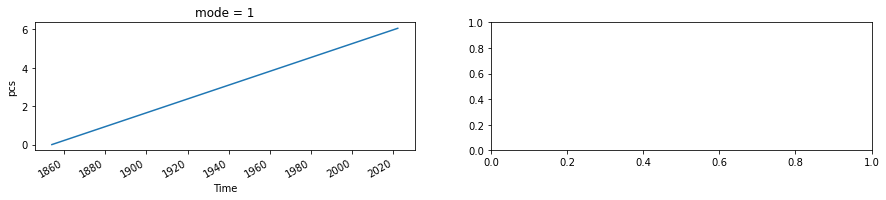

In [60]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

#fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,10))

for i,tsname in enumerate(tsnames):
    ax = plt.subplot(6, 2, 2*i + 1)
    command = tsname+".plot()"
    print(command)
    exec(command)

    ax = plt.subplot(6, 2, 2*i + 2)
    command = tsname+"regC.plot(); plt.title('"+tsname+" regression (oktas/ K in box)')"
    print(command)
    exec(command)